In [1]:
import numpy as np
import matplotlib.pyplot as plt

from squlearn import Executor
from squlearn.feature_map import ChebPQC
from squlearn.expectation_operator import SummedPaulis
from squlearn.qnn import QNNRegressor, SquaredLoss
from squlearn.optimizers import Adam

In [2]:
executor = Executor("statevector_simulator")

Define parameterized quantum circuit $Q(x,\theta)$

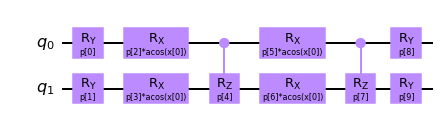

In [3]:
nqubits = 2
pqc = ChebPQC(num_qubits=nqubits, num_features=1, num_layers=2)
pqc.draw()

Definition of the cost operator:
$\hat{H} = J \sum\limits_{i < j} Z_i Z_j + h\sum\limits_i Z_i + c$

In [4]:
op = SummedPaulis(2)
print(op)

SparsePauliOp(['II', 'IZ', 'ZI'],
              coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[2])])


Example function: $log(x)$

In [5]:
x_space = np.arange(-0.5, 0.6, 0.1)
ref_values = np.square(x_space)

np.random.seed(13)
param_ini = np.random.rand(pqc.num_parameters)
param_op_ini = np.ones(op.num_parameters)

reg = QNNRegressor(pqc, op, executor, SquaredLoss(), Adam({"lr":0.1}), param_ini, param_op_ini)

Optimization of the regression

In [6]:
reg.fit(x_space, ref_values)

In [7]:
print("Result Param:", reg.param)
print("Result ParamOp:", reg.param_op)

Result Param: [0.77770241 0.23754122 0.82427853 0.9657492  0.97260111 0.45344925
 0.60904246 0.77552651 0.64161334 0.72201823]
Result ParamOp: [1. 1. 1.]


C:\Users\DKR\Documents\Git Repositories\squlearn_fork\squlearn\src\squlearn\qnn\qnnr.py:136: UserWarning: The model is not fitted.
  warn("The model is not fitted.")


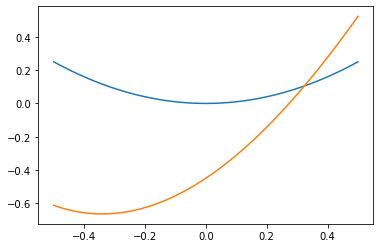

In [8]:
x = np.arange(np.min(x_space), np.max(x_space)+0.01, 0.01)
y = reg.predict(x)
plt.plot(x, np.square(x))
plt.plot(x, y)

In [9]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Estimator
from qiskit_aer.noise import NoiseModel

service = QiskitRuntimeService(channel="ibm_quantum",token="1e1fcef3940bc7181262dbc135a052e83b17a669f187b1d6d7bde96ef3167078b55eb494f44f3b3de8ea934023da7a5eef3df4c6d27bf8ce7d48ca174c654cb7")
noisy_backend = service.get_backend('ibm_nairobi')
backend_noise_model = NoiseModel.from_backend(noisy_backend)
simulator = service.get_backend('ibmq_qasm_simulator')
session = Session(service,backend=simulator)

C:\Users\DKR\Documents\Git Repositories\squlearn_fork\squlearn\src\squlearn\qnn\qnnr.py:136: UserWarning: The model is not fitted.
  warn("The model is not fitted.")


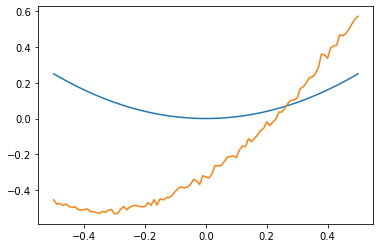

In [10]:
options = Options()
options.resilience_level = 0
options.optimization_level = 0
options.simulator = {
    "noise_model": backend_noise_model,
    "coupling_map": noisy_backend.configuration().coupling_map
}
options.execution.shots = 10000

executor_backend = Executor(Estimator(session,options),caching=False)
qnn_backend = QNNRegressor(pqc, op, executor_backend, SquaredLoss(), Adam(), reg.param, reg.param_op, caching=False)
x = np.arange(np.min(x_space), np.max(x_space)+0.01, 0.01)
y = qnn_backend.predict(x)
plt.plot(x, np.square(x))
plt.plot(x, y)

In [11]:
qnn_backend.get_params()

{'batch_size': None,
 'caching': False,
 'epochs': None,
 'executor': <squlearn.util.executor.Executor at 0x25718913fd0>,
 'feature_map': <squlearn.feature_map.feature_map_implemented.cheb_pqc.ChebPQC at 0x25692243cd0>,
 'loss': <squlearn.qnn.loss.SquaredLoss at 0x25718913ac0>,
 'operator': SparsePauliOp(['II', 'IZ', 'ZI'],
               coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1]),
  ParameterExpression(1.0*p[2])]),
 'opt_param_op': True,
 'optimizer': <squlearn.optimizers.adam.Adam at 0x2571ac32740>,
 'param_ini': array([0.77770241, 0.23754122, 0.82427853, 0.9657492 , 0.97260111,
        0.45344925, 0.60904246, 0.77552651, 0.64161334, 0.72201823]),
 'param_op_ini': array([1., 1., 1.]),
 'parameter_seed': 0,
 'shuffle': None,
 'variance': None,
 'num_qubits': 2,
 'num_features': 1,
 'num_layers': 2,
 'closed': True,
 'entangling_gate': 'crz',
 'op_str': 'Z',
 'full_sum': True,
 'include_identity': True}

C:\Users\DKR\Documents\Git Repositories\squlearn_fork\squlearn\src\squlearn\qnn\qnnr.py:136: UserWarning: The model is not fitted.
  warn("The model is not fitted.")


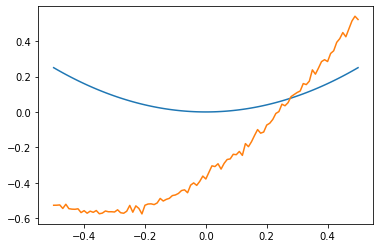

In [12]:
options = Options()
options.resilience_level = 2
options.optimization_level = 0
options.simulator = {
    "noise_model": backend_noise_model,
    "coupling_map": noisy_backend.configuration().coupling_map
}
options.execution.shots = 10000

executor_backend.reset_options_estimator(options)

x = np.arange(np.min(x_space), np.max(x_space)+0.01, 0.01)
y = qnn_backend.predict(x)
plt.plot(x, np.square(x))
plt.plot(x, y)

In [13]:
options = Options()
options.resilience_level = 3
options.optimization_level = 0
options.simulator = {
    "noise_model": backend_noise_model,
    "coupling_map": noisy_backend.configuration().coupling_map
}
options.execution.shots = 10000

executor_backend.reset_options_estimator(options)

x = np.arange(np.min(x_space), np.max(x_space)+0.01, 0.01)
y = qnn_backend.predict(x)
plt.plot(x, np.square(x))
plt.plot(x, y)

C:\Users\DKR\Documents\Git Repositories\squlearn_fork\squlearn\src\squlearn\qnn\qnnr.py:136: UserWarning: The model is not fitted.
  warn("The model is not fitted.")
